[Datitos: Aprendizaje profundo](https://datitos.github.io/curso-aprendizaje-profundo/)

[T.P. N°2 - Aprendizaje Profundo 2021 by Datitos](https://www.kaggle.com/c/tp-n2-aprendizaje-profundo-2021-by-datitos-v2)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns

import torch
from torch.nn import Sequential, Softmax
from torch.optim import Adam

from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split

from callbacks import PlotLosses, \
                      Logger, \
                      ReduceLROnPlateau, \
                      TrainValLossComputer

from model import CommonModel, \
                  softmax_cross_entropy_fn, \
                  softmax_pred_out, \
                  dense_stack

from utils import try_gpu
from callbacks import CallbackSet

from metrics import show_summary

In [4]:
train_set = pd.read_csv('./dataset/fifa2021_training.csv')

In [5]:
# ProfileReport(train_set, title="Exploratory Analisys", explorative=True)to_file("report.html")

In [6]:
SKILL_FEATURES = [
    'BallControl', 'Dribbling', 'Marking', 'SlideTackle', 'StandTackle', 'Aggression',
    'Reactions', 'Interceptions', 'Vision', 'Composure', 'Crossing', 'ShortPass',
    'LongPass', 'Acceleration', 'Stamina', 'Strength', 'Balance', 'SprintSpeed',
    'Agility', 'Jumping', 'Heading', 'ShotPower', 'Finishing', 'LongShots',
    'Curve', 'FKAcc', 'Penalties', 'Volleys', 'GKDiving', 'GKHandling',
    'GKKicking', 'GKReflexes'
]
TARGET = 'Position'

In [7]:
def preprocess(df): return df[SKILL_FEATURES], pd.get_dummies(df[[TARGET]], dummy_na=False)

In [8]:
def plot_df_clases_count(df, class_col):
    groups = train_set[[class_col]] \
      .groupby(class_col) \
      .size() \
      .reset_index(name='count')
    sns.barplot(data=groups, x=class_col, y='count')

def plot_array_clases_count(values):
    groups = values \
        .mean() \
        .reset_index(name='count') \
        .rename(columns={"index": "Name"})

    sns.barplot(data=groups, x="Name", y='count')

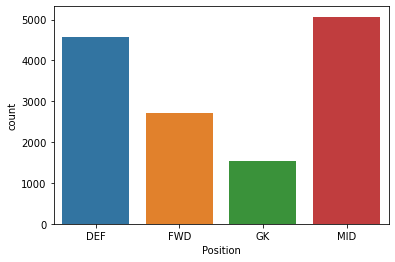

In [11]:
plot_df_clases_count(train_set, TARGET)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    *preprocess(train_set), 
    test_size=0.2,
    stratify=train_set[TARGET]
)

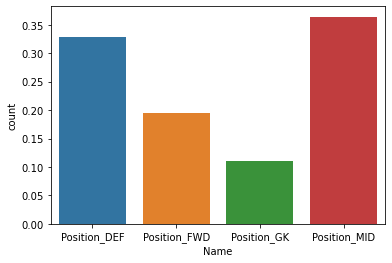

In [13]:
plot_array_clases_count(y_train)

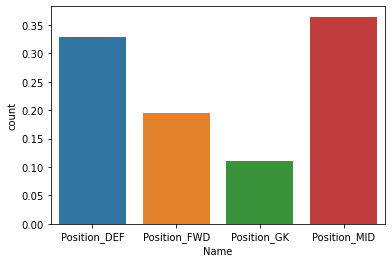

In [14]:
plot_array_clases_count(y_val)

In [15]:
class MyModel(CommonModel):
    def __init__(self, n_units, lr=0.001, dropout=0.2):
        model = Sequential(*dense_stack(n_units, dropout), Softmax(dim=1)).to(device=try_gpu())
        super().__init__(model, softmax_cross_entropy_fn, Adam(model.parameters(), lr=lr), softmax_pred_out)

In [16]:
model = MyModel(
    n_units = [X_train.shape[1], 100, 50, 25, y_train.shape[1]],
    lr      = 0.001, 
    dropout = 0.2
).info()

Model:
 Sequential(
  (0): Linear(in_features=32, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=100, out_features=50, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=50, out_features=25, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=25, out_features=4, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Softmax(dim=1)
)
Params:
 [('0.weight', torch.Size([100, 32])), ('0.bias', torch.Size([100])), ('3.weight', torch.Size([50, 100])), ('3.bias', torch.Size([50])), ('6.weight', torch.Size([25, 50])), ('6.bias', torch.Size([25])), ('9.weight', torch.Size([4, 25])), ('9.bias', torch.Size([4]))]


### Train

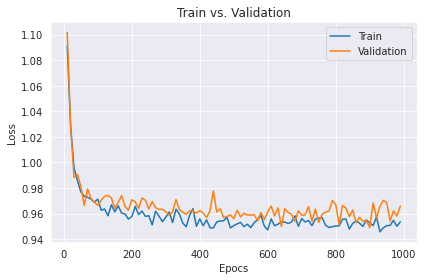

{'epoch': 1000, 'lr': 1.0000000000000004e-08, 'train_loss': 0.9521728157997131, 'val_loss': 0.9677299857139587}


In [17]:
model.fit(
    train_set    = (X_train, y_train), 
    val_set      = (X_val, y_val),
    batch_size   = 4096,
    epochs       = 1000,
    callback_set = CallbackSet([
        TrainValLossComputer(),
        PlotLosses(),
        Logger(metrics=['epoch', 'train_loss', 'val_loss', 'lr']),
        ReduceLROnPlateau(patience=100)
    ])
)

### Predict

In [33]:
y_true       = pd.DataFrame({ 'y_true': np.argmax(y_val.values, axis=1)})
y_pred       = pd.DataFrame({ 'y_pred': model.predict(X_val)})
y_pred_proba = model.predict_proba(X_val)

Accuracy: 79.0305 %

Classification Report:
              precision    recall  f1-score   support

Position_DEF       0.71      0.93      0.80       917
Position_FWD       0.84      0.65      0.73       543
 Position_GK       1.00      0.82      0.90       310
Position_MID       0.82      0.73      0.77      1015

    accuracy                           0.79      2785
   macro avg       0.84      0.78      0.80      2785
weighted avg       0.81      0.79      0.79      2785



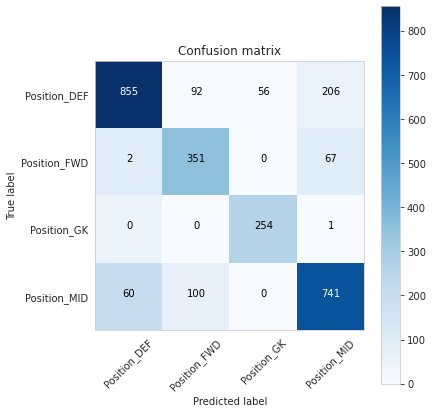

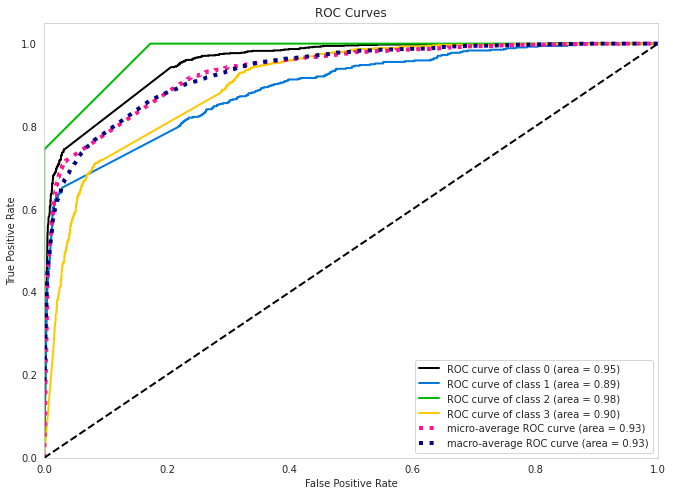

In [40]:
show_summary(y_true, y_pred, y_pred_proba, labels=list(y_val.columns.values))